**Import Libraries**

In [82]:
import os
import copy
import numpy as np
import pandas as pd
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from scipy.special import softmax

import matplotlib.pyplot as plt

import torchvision.transforms as T
from collections import Counter

**Load and Preprocess Data**

In [83]:
def load_images_from_csv(data_dir, csv_path, image_size=(50, 50), limit=None):
    """
    data_dir:    Directory containing 'train_images' folder.
    csv_path:    Path to the CSV file (with columns 'image_id', 'label').
    image_size:  (height, width) to resize images.
    limit:       If not None, limit to this many images (for debugging).
    
    Returns:
      X: A NumPy array of shape (N, H*W*3) if flattened, or (N, 3, H, W) if not flattened.
      y: A NumPy array of labels (N,).
    """
    df = pd.read_csv(csv_path)
    if limit is not None:
        df = df.head(limit)

    all_images = []
    all_labels = []

    for _, row in df.iterrows():
        image_id = row['image_id']
        label = row['label']

        # Load image via PIL
        img_path = os.path.join(data_dir, 'train_images', image_id)
        with Image.open(img_path) as pil_img:
            # Convert to RGB
            pil_img = pil_img.convert('RGB')
            
            # Resize using PIL
            pil_img = pil_img.resize(image_size, Image.BILINEAR)

            # Convert to NumPy array
            img_np = np.array(pil_img)  # shape: (H, W, 3)

            img_np_flat = img_np.flatten()  # shape: (H*W*3,)

            all_images.append(img_np_flat)
            all_labels.append(label)

    X = np.array(all_images)
    y = np.array(all_labels)
    return X, y

data_dir = '.'
csv_path = os.path.join(data_dir, 'train.csv')
IMAGE_SIZE = (64, 64)

X, y = load_images_from_csv(
    data_dir=data_dir, 
    csv_path=csv_path, 
    image_size=IMAGE_SIZE, 
)

**Augmentation**

In [84]:
def augment_class(X, y, class_label, transform, required_samples, image_size=(64, 64)):
    """
    Augment the dataset for a specific class to match the majority class.

    Parameters:
        X (np.ndarray): Dataset of flattened images, shape (N, H*W*3).
        y (np.ndarray): Corresponding labels, shape (N,).
        class_label (int): The class label to augment.
        transform (torchvision.transforms.Compose): Transformations for augmentation.
        required_samples (int): Total number of samples needed for this class after augmentation.
        image_size (tuple): Original image dimensions (H, W).

    Returns:
        X_aug (np.ndarray): Augmented dataset for the class, shape (required_samples, H*W*3).
        y_aug (np.ndarray): Corresponding labels for the augmented data.
    """
    H, W = image_size
    # Find indices of the samples belonging to the class_label
    class_indices = np.where(y == class_label)[0]
    
    if len(class_indices) == 0:
        print(f"No samples found for class {class_label}. Skipping augmentation.")
        return np.empty((0, X.shape[1]), dtype=X.dtype), np.empty(0, dtype=y.dtype)
    
    current_samples = len(class_indices)
    augment_factor = -(-required_samples // current_samples)  # Ceiling division
    total_needed = required_samples - current_samples

    augmented_images = []
    augmented_labels = []

    for idx in class_indices:
        base_image_flat = X[idx]  # shape: H*W*3
        label = y[idx]

        # Convert flat array to (H, W, 3) and to PIL.Image
        base_image_3d = base_image_flat.reshape((H, W, 3)).astype(np.uint8)
        base_image_pil = Image.fromarray(base_image_3d, mode='RGB')

        # Create augmented versions
        for _ in range(augment_factor):
            if len(augmented_images) >= total_needed:
                break
            aug_pil = transform(base_image_pil)  
            # Convert tensor (3, H, W) -> (H, W, 3)
            aug_np = (aug_pil.permute(1, 2, 0).numpy() * 255).clip(0, 255).astype(np.uint8)

            # Flatten the augmented image
            aug_np_flat = aug_np.flatten()
            augmented_images.append(aug_np_flat)
            augmented_labels.append(label)

    # Convert lists to NumPy arrays
    X_aug = np.array(augmented_images, dtype=X.dtype)
    y_aug = np.array(augmented_labels, dtype=y.dtype)
    
    return X_aug, y_aug

def balance_classes_to_majority(X, y, transform, image_size=(64, 64)):
    """
    Balance the dataset by augmenting underrepresented classes to match the majority class size.

    Parameters:
        X (np.ndarray): Dataset of flattened images, shape (N, H*W*3).
        y (np.ndarray): Corresponding labels, shape (N,).
        transform (torchvision.transforms.Compose): Transformations for augmentation.
        image_size (tuple): Original image dimensions (H, W).

    Returns:
        X_balanced (np.ndarray): Dataset balanced to the size of the majority class.
        y_balanced (np.ndarray): Corresponding labels for the balanced dataset.
    """
    # Get the class distribution
    class_counts = Counter(y)
    max_samples = max(class_counts.values())  # Size of the majority class

    X_balanced = []
    y_balanced = []

    for class_label, count in class_counts.items():
        # Get current class samples
        class_indices = np.where(y == class_label)[0]
        X_class = X[class_indices]
        y_class = y[class_indices]

        X_balanced.append(X_class)
        y_balanced.append(y_class)

        if count < max_samples:
            # Augment samples to match the majority class size
            required_samples = max_samples - count
            X_aug, y_aug = augment_class(
                X, y, class_label, transform, required_samples, image_size
            )

            X_balanced.append(X_aug)
            y_balanced.append(y_aug)

    # Combine all classes into a single dataset
    X_balanced = np.vstack(X_balanced)
    y_balanced = np.hstack(y_balanced)

    print("Final class distribution after augmentation:")
    final_class_counts = Counter(y_balanced)
    for label, count in final_class_counts.items():
        print(f"Class {label}: {count} samples")

    return X_balanced, y_balanced


# Define improved augmentation pipeline with corrected order
train_transform = T.Compose([
    T.RandomHorizontalFlip(p=0.5),            # Random horizontal flip
    T.RandomRotation(degrees=15),              # Random rotation
    T.RandomResizedCrop(size=IMAGE_SIZE, scale=(0.8, 1.0)),  # Random resized crop
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Color jitter
    T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Add GaussianBlur here
    T.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=10),  # Random affine
    T.RandomPerspective(distortion_scale=0.2, p=0.5, interpolation=3),  # Random perspective
    T.ToTensor(),                             # Convert to tensor first
    T.RandomErasing(p=0.2),                   # Random erasing for occlusion
])

# Apply the updated balancing function
X_balanced, y_balanced = balance_classes_to_majority(
    X,
    y,
    transform=train_transform,
    image_size=IMAGE_SIZE,
)

print("Original shape:", X.shape, "| Balanced shape:", X_balanced.shape)

Final class distribution after augmentation:
Class 0: 12071 samples
Class 3: 13158 samples
Class 1: 10969 samples
Class 2: 10772 samples
Class 4: 10581 samples
Original shape: (21397, 12288) | Balanced shape: (57551, 12288)


**Encode Labels**

In [85]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_balanced)

class_names = label_encoder.classes_
num_classes = len(class_names)

**Split Dataset**

In [86]:
# First split into train + (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X_balanced, y_encoded, test_size=0.4, random_state=42)

# Then split (validation + test) into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

**Normalize**

In [87]:
# Calculate mean and standard deviation from the training group
train_mean = X_train.mean(axis=0)
train_std = X_train.std(axis=0)

# Normalize the training data
X_train_normalized = (X_train - train_mean) / train_std

# Apply the same normalization to the validation and test datasets
X_val_normalized = (X_val - train_mean) / train_std
X_test_normalized = (X_test - train_mean) / train_std

**Prepare Data for PyTorch**

In [88]:
# Convert to tensors
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
X_train_torch = torch.tensor(X_train_normalized, dtype=torch.float32)
X_val_torch = torch.tensor(X_val_normalized, dtype=torch.float32)
X_test_torch = torch.tensor(X_test_normalized, dtype=torch.float32)

class ImageDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ImageDataset(X_train_torch, y_train_tensor)
val_dataset = ImageDataset(X_val_torch, y_val_tensor)
test_dataset = ImageDataset(X_test_torch, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

**Define the Model**

In [89]:
class SoftmaxRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Initialize Softmax Regression with input and output dimensions.
        Args:
            input_dim (int): Number of input features.
            output_dim (int): Number of output classes.
        """
        super(SoftmaxRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        """
        Forward pass: compute logits.
        Args:
            x (Tensor): Input tensor of shape (batch_size, input_dim).
        Returns:
            Tensor: Logits of shape (batch_size, output_dim).
        """
        logits = self.linear(x)  # Compute logits (raw scores)
        return logits  # Return raw logits without softmax
    
    def predict(self, x):
        """
        Predict class labels from input features.
        Args:
            x (Tensor): Input tensor of shape (batch_size, input_dim).
        Returns:
            Tensor: Predicted class labels of shape (batch_size).
        """
        logits = self.forward(x)
        return torch.argmax(logits, dim=1)  # Get the class with the highest logit


# Model initialization
input_dim = X_train_torch.shape[1]  # Number of features
output_dim = num_classes  # Number of classes
model = SoftmaxRegression(input_dim, output_dim)

**Train the Model**

In [90]:
def train(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001, patience=7, alpha=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate , weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_loss = float('inf')
    best_model_state = None
    no_improve_count = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss_ce = criterion(outputs, labels)

            # L1 regularization
            l1_penalty = torch.tensor(0., requires_grad=True).to(device)
            for name, param in model.named_parameters():
                if "weight" in name and "bn" not in name:  # Exclude biases and BatchNorm parameters
                    l1_penalty += torch.norm(param, p=1)

            # Total loss
            total_loss = loss_ce + alpha * l1_penalty

            total_loss.backward()
            
            # Add gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            

            running_loss += total_loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accs.append(100. * correct / total)

        model.eval()
        val_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss_ce = criterion(outputs, labels)

                # L1 regularization in validation
                l1_penalty = torch.tensor(0., requires_grad=False).to(device)
                for name, param in model.named_parameters():
                    if "weight" in name and "bn" not in name:  # Exclude biases and BatchNorm parameters
                        l1_penalty += torch.norm(param, p=1)

                total_loss = loss_ce + alpha * l1_penalty
                val_loss += total_loss.item()

                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(100. * correct / total)
        
        # Learning rate scheduling
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.2f}%")

        # Early stopping mechanism
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            best_model_state = copy.deepcopy(model.state_dict())
            no_improve_count = 0
        else:
            no_improve_count += 1

        if no_improve_count >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    # Restore the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return train_losses, val_losses, train_accs, val_accs


train_losses, val_losses, train_accs, val_accs = train(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001)

Epoch 1/50, Train Loss: 2.2717, Train Acc: 36.46%
Epoch 2/50, Train Loss: 2.1634, Train Acc: 37.97%
Epoch 3/50, Train Loss: 2.1348, Train Acc: 37.85%
Epoch 4/50, Train Loss: 2.1440, Train Acc: 37.41%
Epoch 5/50, Train Loss: 2.1305, Train Acc: 37.86%
Epoch 6/50, Train Loss: 2.1733, Train Acc: 38.08%
Epoch 7/50, Train Loss: 2.1184, Train Acc: 37.91%
Epoch 8/50, Train Loss: 2.1252, Train Acc: 38.16%
Epoch 9/50, Train Loss: 2.1350, Train Acc: 38.23%
Epoch 00010: reducing learning rate of group 0 to 5.0000e-04.
Epoch 10/50, Train Loss: 2.1564, Train Acc: 37.76%
Epoch 11/50, Train Loss: 1.7080, Train Acc: 40.86%
Epoch 12/50, Train Loss: 1.6854, Train Acc: 40.94%
Epoch 13/50, Train Loss: 1.6894, Train Acc: 40.79%
Epoch 14/50, Train Loss: 1.6791, Train Acc: 40.88%
Epoch 00015: reducing learning rate of group 0 to 2.5000e-04.
Epoch 15/50, Train Loss: 1.6656, Train Acc: 40.87%
Epoch 16/50, Train Loss: 1.4936, Train Acc: 43.62%
Epoch 17/50, Train Loss: 1.4721, Train Acc: 43.74%
Epoch 18/50, Train

**Visualize Metrics**

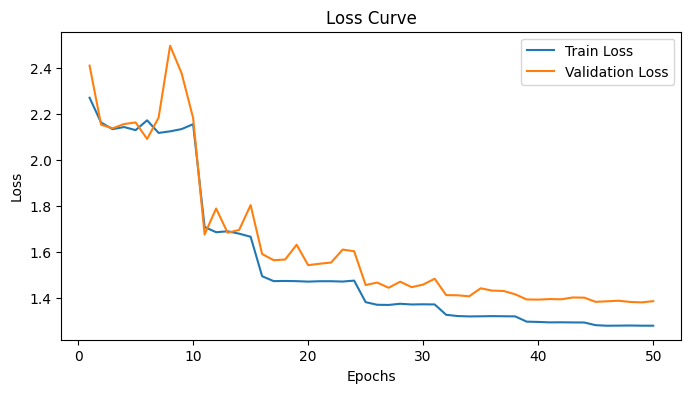

In [91]:
def plot_loss(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 4))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()

plot_loss(train_losses, val_losses)

**Evaluate the Model**

In [92]:
def evaluate(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# Evaluate on train set
y_train_true, y_train_pred = evaluate(model, train_loader)

# Evaluate on test set
y_test_true, y_test_pred = evaluate(model, test_loader)

# Print metrics
accuracy_train = accuracy_score(y_train_true, y_train_pred)
accuracy_test = accuracy_score(y_test_true, y_test_pred)
f1_test = f1_score(y_test_true, y_test_pred, average='weighted')

print(f'Training Accuracy: {accuracy_train:.3f}')
print(f'Test Accuracy: {accuracy_test:.3f}')
print(f'F1 Score: {f1_test:.3f}')
print("Classification Report:")
print(classification_report(y_test_true, y_test_pred, zero_division=0))

Training Accuracy: 0.500
Test Accuracy: 0.436
F1 Score: 0.399
Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.53      0.47      2467
           1       0.30      0.19      0.23      2235
           2       0.33      0.32      0.32      2130
           3       0.62      0.92      0.74      2574
           4       0.24      0.11      0.15      2105

    accuracy                           0.44     11511
   macro avg       0.38      0.41      0.38     11511
weighted avg       0.39      0.44      0.40     11511

